In [1]:
import os 

#walk through the directory and list the numbers of files
for dirpath, dirnames, filenames in os.walk("/kaggle/input/bird-species"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 3 directories and 2 images in /kaggle/input/bird-species
There are 525 directories and 0 images in /kaggle/input/bird-species/valid
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/DALMATIAN PELICAN
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/BLACK BREASTED PUFFBIRD
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/WATTLED CURASSOW
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/AMERICAN WIGEON
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/CARMINE BEE-EATER
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/GAMBELS QUAIL
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/UMBRELLA BIRD
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/AMERICAN KESTREL
There are 0 directories and 5 images in /kaggle/input/bird-species/valid/AMERICAN GOLDFINCH
There are 0 directories and 5 images in /kag

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)


2025-04-28 18:08:55.134627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745863735.330201      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745863735.387496      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [3]:
dataset = {
             "train_data" : "/kaggle/input/bird-species/train",
             "valid_data" : "/kaggle/input/bird-species/valid",
             "test_data" : "/kaggle/input/bird-species/test"
          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])


In [ ]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [5]:
train_df.sample(n=15, random_state=1)

In [6]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath             labels
0  /kaggle/input/bird-species/train/DALMATIAN PEL...  DALMATIAN PELICAN
1  /kaggle/input/bird-species/train/DALMATIAN PEL...  DALMATIAN PELICAN
2  /kaggle/input/bird-species/train/DALMATIAN PEL...  DALMATIAN PELICAN
3  /kaggle/input/bird-species/train/DALMATIAN PEL...  DALMATIAN PELICAN
4  /kaggle/input/bird-species/train/DALMATIAN PEL...  DALMATIAN PELICAN
(84635, 3)
--------Validation----------
                                             imgpath             labels
0  /kaggle/input/bird-species/valid/DALMATIAN PEL...  DALMATIAN PELICAN
1  /kaggle/input/bird-species/valid/DALMATIAN PEL...  DALMATIAN PELICAN
2  /kaggle/input/bird-species/valid/DALMATIAN PEL...  DALMATIAN PELICAN
3  /kaggle/input/bird-species/valid/DALMATIAN PEL...  DALMATIAN PELICAN
4  /kaggle/input/bird-species/valid/DALMATIAN PEL...  DALMATIAN PELICAN
(2625, 3)
----------Test--------------
                            

In [7]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [8]:
%%time

BATCH_SIZE = 35
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 84635 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
CPU times: user 672 ms, sys: 2.13 s, total: 2.8 s
Wall time: 46.5 s


In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB5(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False


I0000 00:00:1745863800.756734      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745863800.757614      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.12),
    layers.RandomContrast(0.12),
], name='AugmentationLayer')




inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(1024)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(512)(x)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb5 (Functional)          │ (None, 2048)                │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 525)                 │         269,325 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 525)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 525)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,411,972 (119.83 MB)

 Trainable params: 2,895,373 (11.04 MB)

 Non-trainable params: 28,516,599 (108.78 MB)

None


In [11]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)



Epoch 1/10


I0000 00:00:1745863856.310124      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


2419/2419 ━━━━━━━━━━━━━━━━━━━━ 617s 235ms/step - accuracy: 0.2434 - loss: 3.9086 - val_accuracy: 0.7322 - val_loss: 0.9748 - learning_rate: 5.0000e-04
Epoch 2/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 567s 234ms/step - accuracy: 0.5721 - loss: 1.7238 - val_accuracy: 0.8225 - val_loss: 0.6421 - learning_rate: 5.0000e-04
Epoch 3/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 566s 234ms/step - accuracy: 0.6202 - loss: 1.5160 - val_accuracy: 0.8442 - val_loss: 0.5728 - learning_rate: 5.0000e-04
Epoch 4/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 566s 234ms/step - accuracy: 0.6454 - loss: 1.4076 - val_accuracy: 0.8705 - val_loss: 0.4572 - learning_rate: 5.0000e-04
Epoch 5/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 568s 235ms/step - accuracy: 0.6578 - loss: 1.3501 - val_accuracy: 0.8514 - val_loss: 0.5086 - learning_rate: 5.0000e-04
Epoch 6/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 569s 235ms/step - accuracy: 0.6729 - loss: 1.2824 - val_accuracy: 0.8743 - val_loss: 0.4305 - learning_rate: 5.0000e-04
Epoch 7/10
2419/2419 ━━━━━━━━━━━━━━━━━━

In [13]:
import os

# Create folder if it doesn't exist
os.makedirs('./checkpoints', exist_ok=True)

# Now save the weights
model.save_weights('./checkpoints/my_checkpoint.weights.h5')


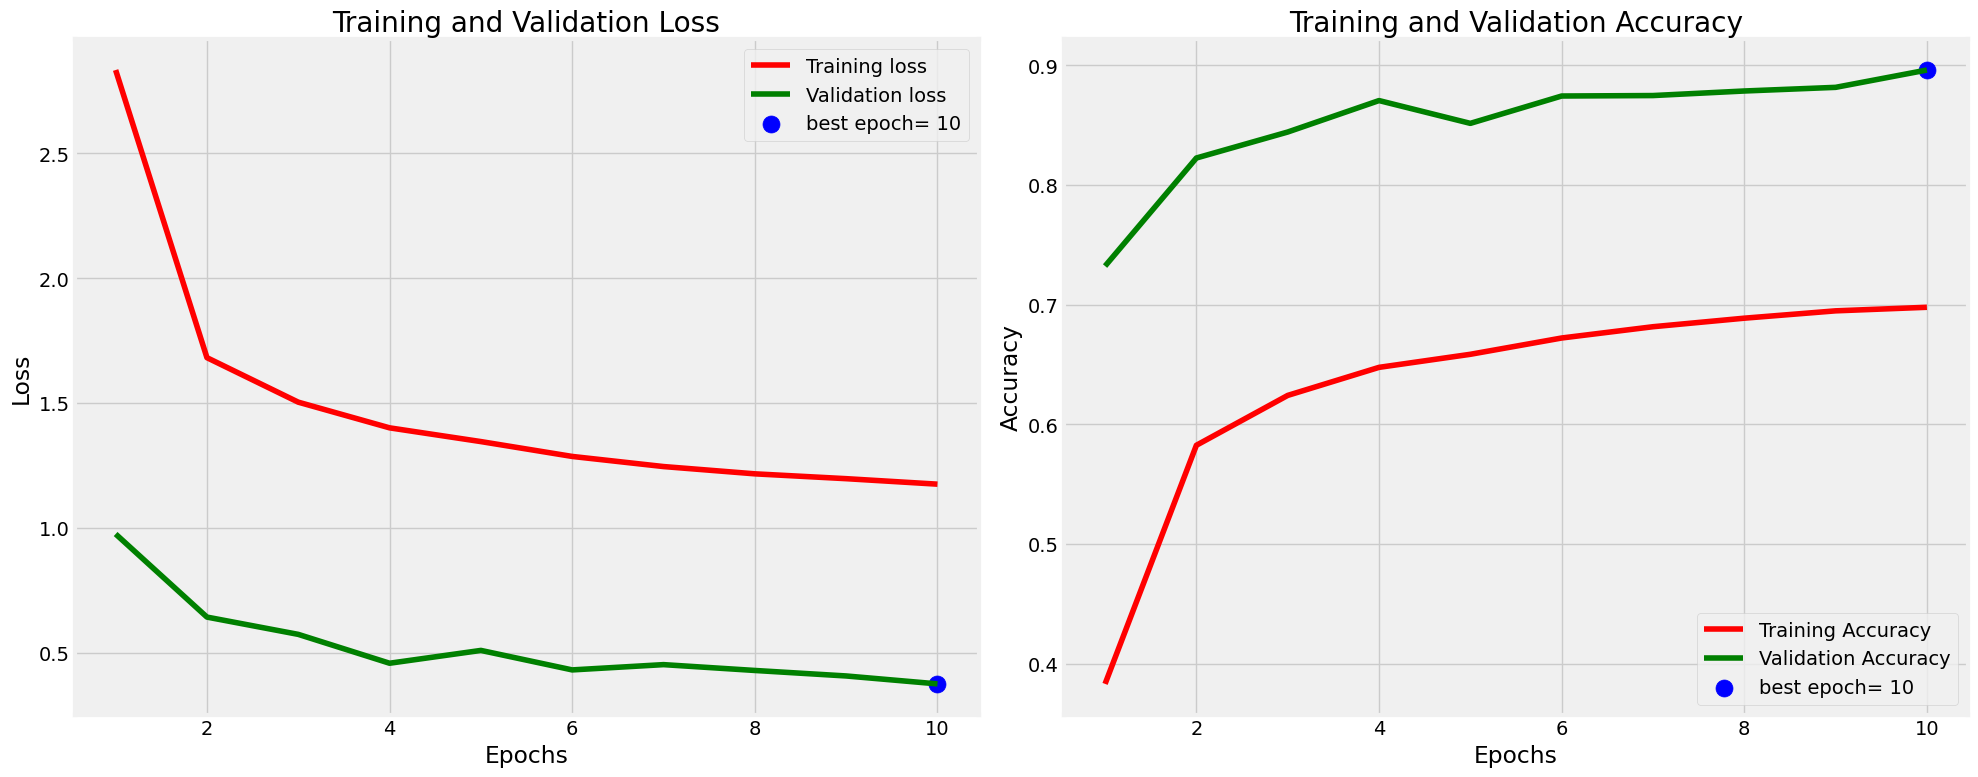

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Let's see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

import os
os.makedirs('./checkpoints', exist_ok=True)
model.save_weights('./checkpoints/my_checkpoint.weights.h5')


input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb5 (Functional)          │ (None, 2048)                │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 525)                 │         269,325 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 525)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 525)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,411,972 (119.83 MB)

 Trainable params: 2,895,373 (11.04 MB)

 Non-trainable params: 28,516,599 (108.78 MB)

None
Epoch 1/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 619s 238ms/step - accuracy: 0.7320 - loss: 1.0342 - val_accuracy: 0.9200 - val_loss: 0.3062 - learning_rate: 1.0000e-05
Epoch 2/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 567s 234ms/step - accuracy: 0.7384 - loss: 1.0079 - val_accuracy: 0.9211 - val_loss: 0.3043 - learning_rate: 1.0000e-05
Epoch 3/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 566s 234ms/step - accuracy: 0.7419 - loss: 0.9990 - val_accuracy: 0.9196 - val_loss: 0.3016 - learning_rate: 1.0000e-05
Epoch 4/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 567s 234ms/step - accuracy: 0.7438 - loss: 0.9877 - val_accuracy: 0.9211 - val_loss: 0.2988 - learning_rate: 1.0000e-05
Epoch 5/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 565s 234ms/step - accuracy: 0.7419 - loss: 0.9960 - val_accuracy: 0.9223 - val_loss: 0.2970 - learning_rate: 1.0000e-05
Epoch 6/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 565s 234ms/step - accuracy: 0.7434 - loss: 0.9960 - val_accuracy: 0.9223 - val_loss: 0.2946 - learning_rate: 1.0000e-05
Epoch 7/20
2419/2419 ━━

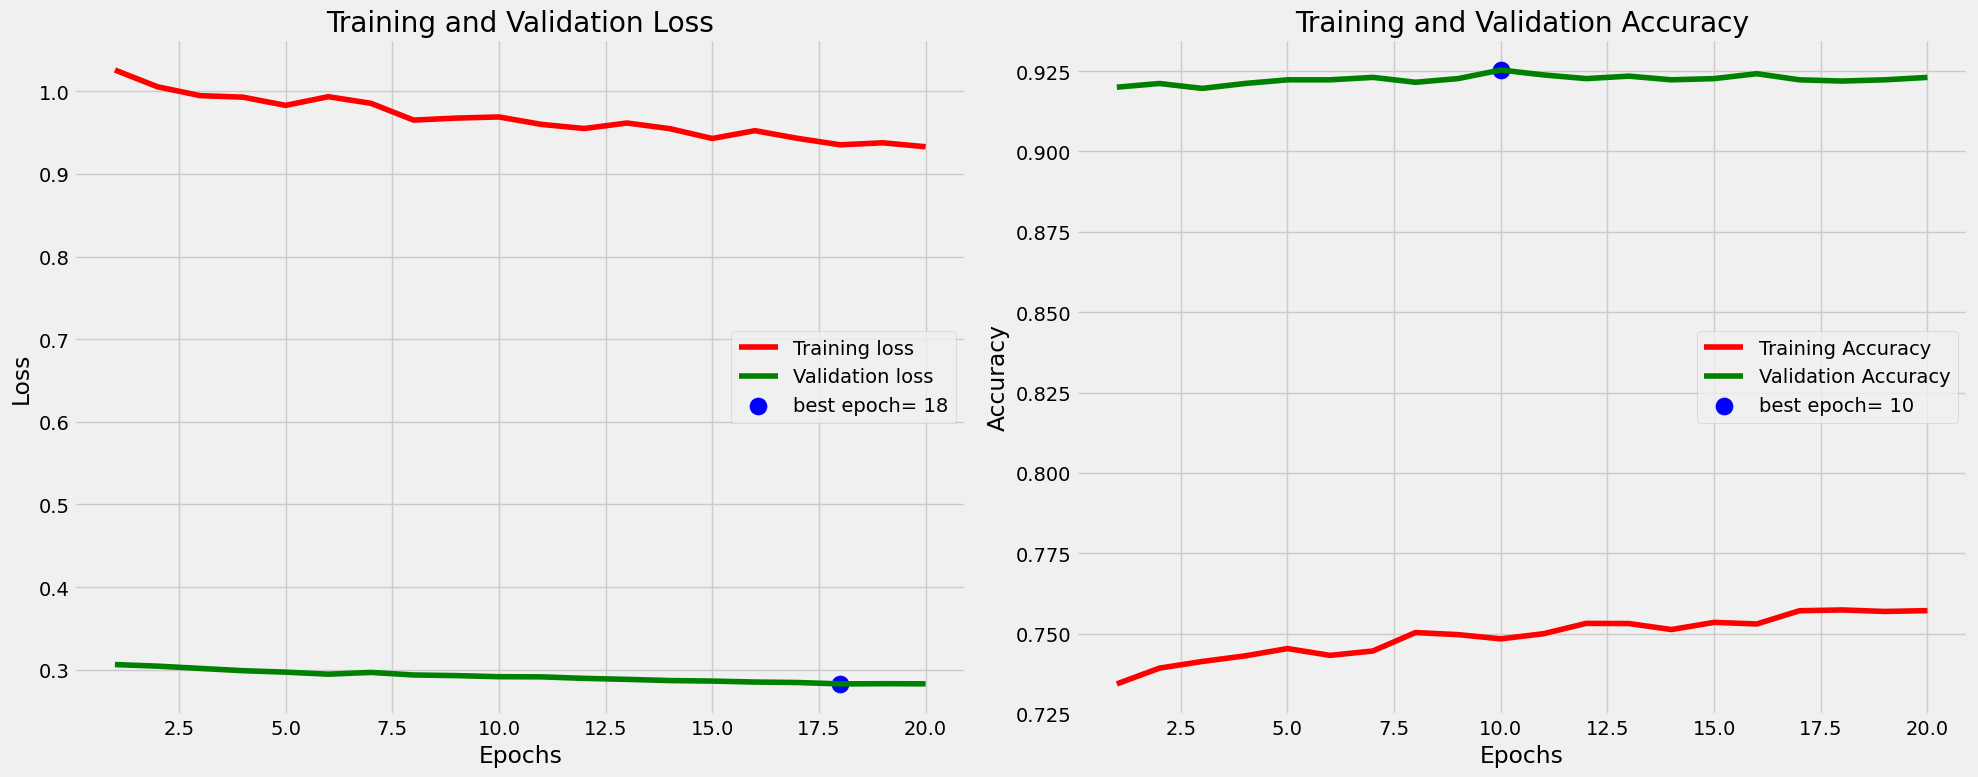

In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.20006
Test Accuracy: 94.17%


In [19]:
# Get true labels
y_true = test_images.classes

# Predict labels
y_pred = np.argmax(model.predict(test_images, steps=len(test_images)), axis=1)

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=list(test_images.class_indices.keys())))


75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step
F1 Score: 0.939638604781462
                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      1.00      1.00         5
                ABBOTTS BOOBY       1.00      0.40      0.57         5
   ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
          AFRICAN PYGMY GOOSE       1.00      0.80      0.89         5
                    ALBATROSS       0.83      1.00      0.91         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
      

In [20]:
# First predict ONCE and store
predictions = model.predict(test_images, steps=len(test_images))
y_pred = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

# Map class indices to labels
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))

# Create dataframe
Predictions = pd.DataFrame({
    "Image Index": list(range(len(test_images.labels))),
    "Test Labels": test_images.labels,
    "Test Classes": [classes[i] for i in test_images.labels],
    "Prediction Labels": y_pred,
    "Prediction Classes": [classes[i] for i in y_pred],
    "Path": test_images.filenames,
    "Prediction Probability": prediction_probs
})

# Show
Predictions.head(8)


75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step


Image Index  Test Labels             Test Classes  Prediction Labels  \
0            0          185        DALMATIAN PELICAN                185   
1            1          185        DALMATIAN PELICAN                185   
2            2          185        DALMATIAN PELICAN                185   
3            3          185        DALMATIAN PELICAN                185   
4            4          185        DALMATIAN PELICAN                185   
5            5           75  BLACK BREASTED PUFFBIRD                 75   
6            6           75  BLACK BREASTED PUFFBIRD                482   
7            7           75  BLACK BREASTED PUFFBIRD                 75   

        Prediction Classes                                               Path  \
0        DALMATIAN PELICAN  /kaggle/input/bird-species/test/DALMATIAN PELI...   
1        DALMATIAN PELICAN  /kaggle/input/bird-species/test/DALMATIAN PELI...   
2        DALMATIAN PELICAN  /kaggle/input/bird-species/test/DALMATIAN PELI...   
3        DALMATIAN PELICAN  /kaggle/input/bird-species/test/DALMATIAN PELI...   
4        DALMATIAN PELICAN  /kaggle/input/bird-species/test/DALMATIAN PELI...   
5  BLACK BREASTED PUFFBIRD  /kaggle/input/bird-species/test/BLACK BREASTED...   
6             TREE SWALLOW  /kaggle/input/bird-species/test/BLACK BREASTED...   
7  BLACK BREASTED PUFFBIRD  /kaggle/input/bird-species/test/BLACK BREASTED...   

   Prediction Probability  
0                0.999687  
1                0.999960  
2                0.999957  
3                0.999974  
4                0.999588  
5                0.996496  
6                0.655438  
7                0.967765

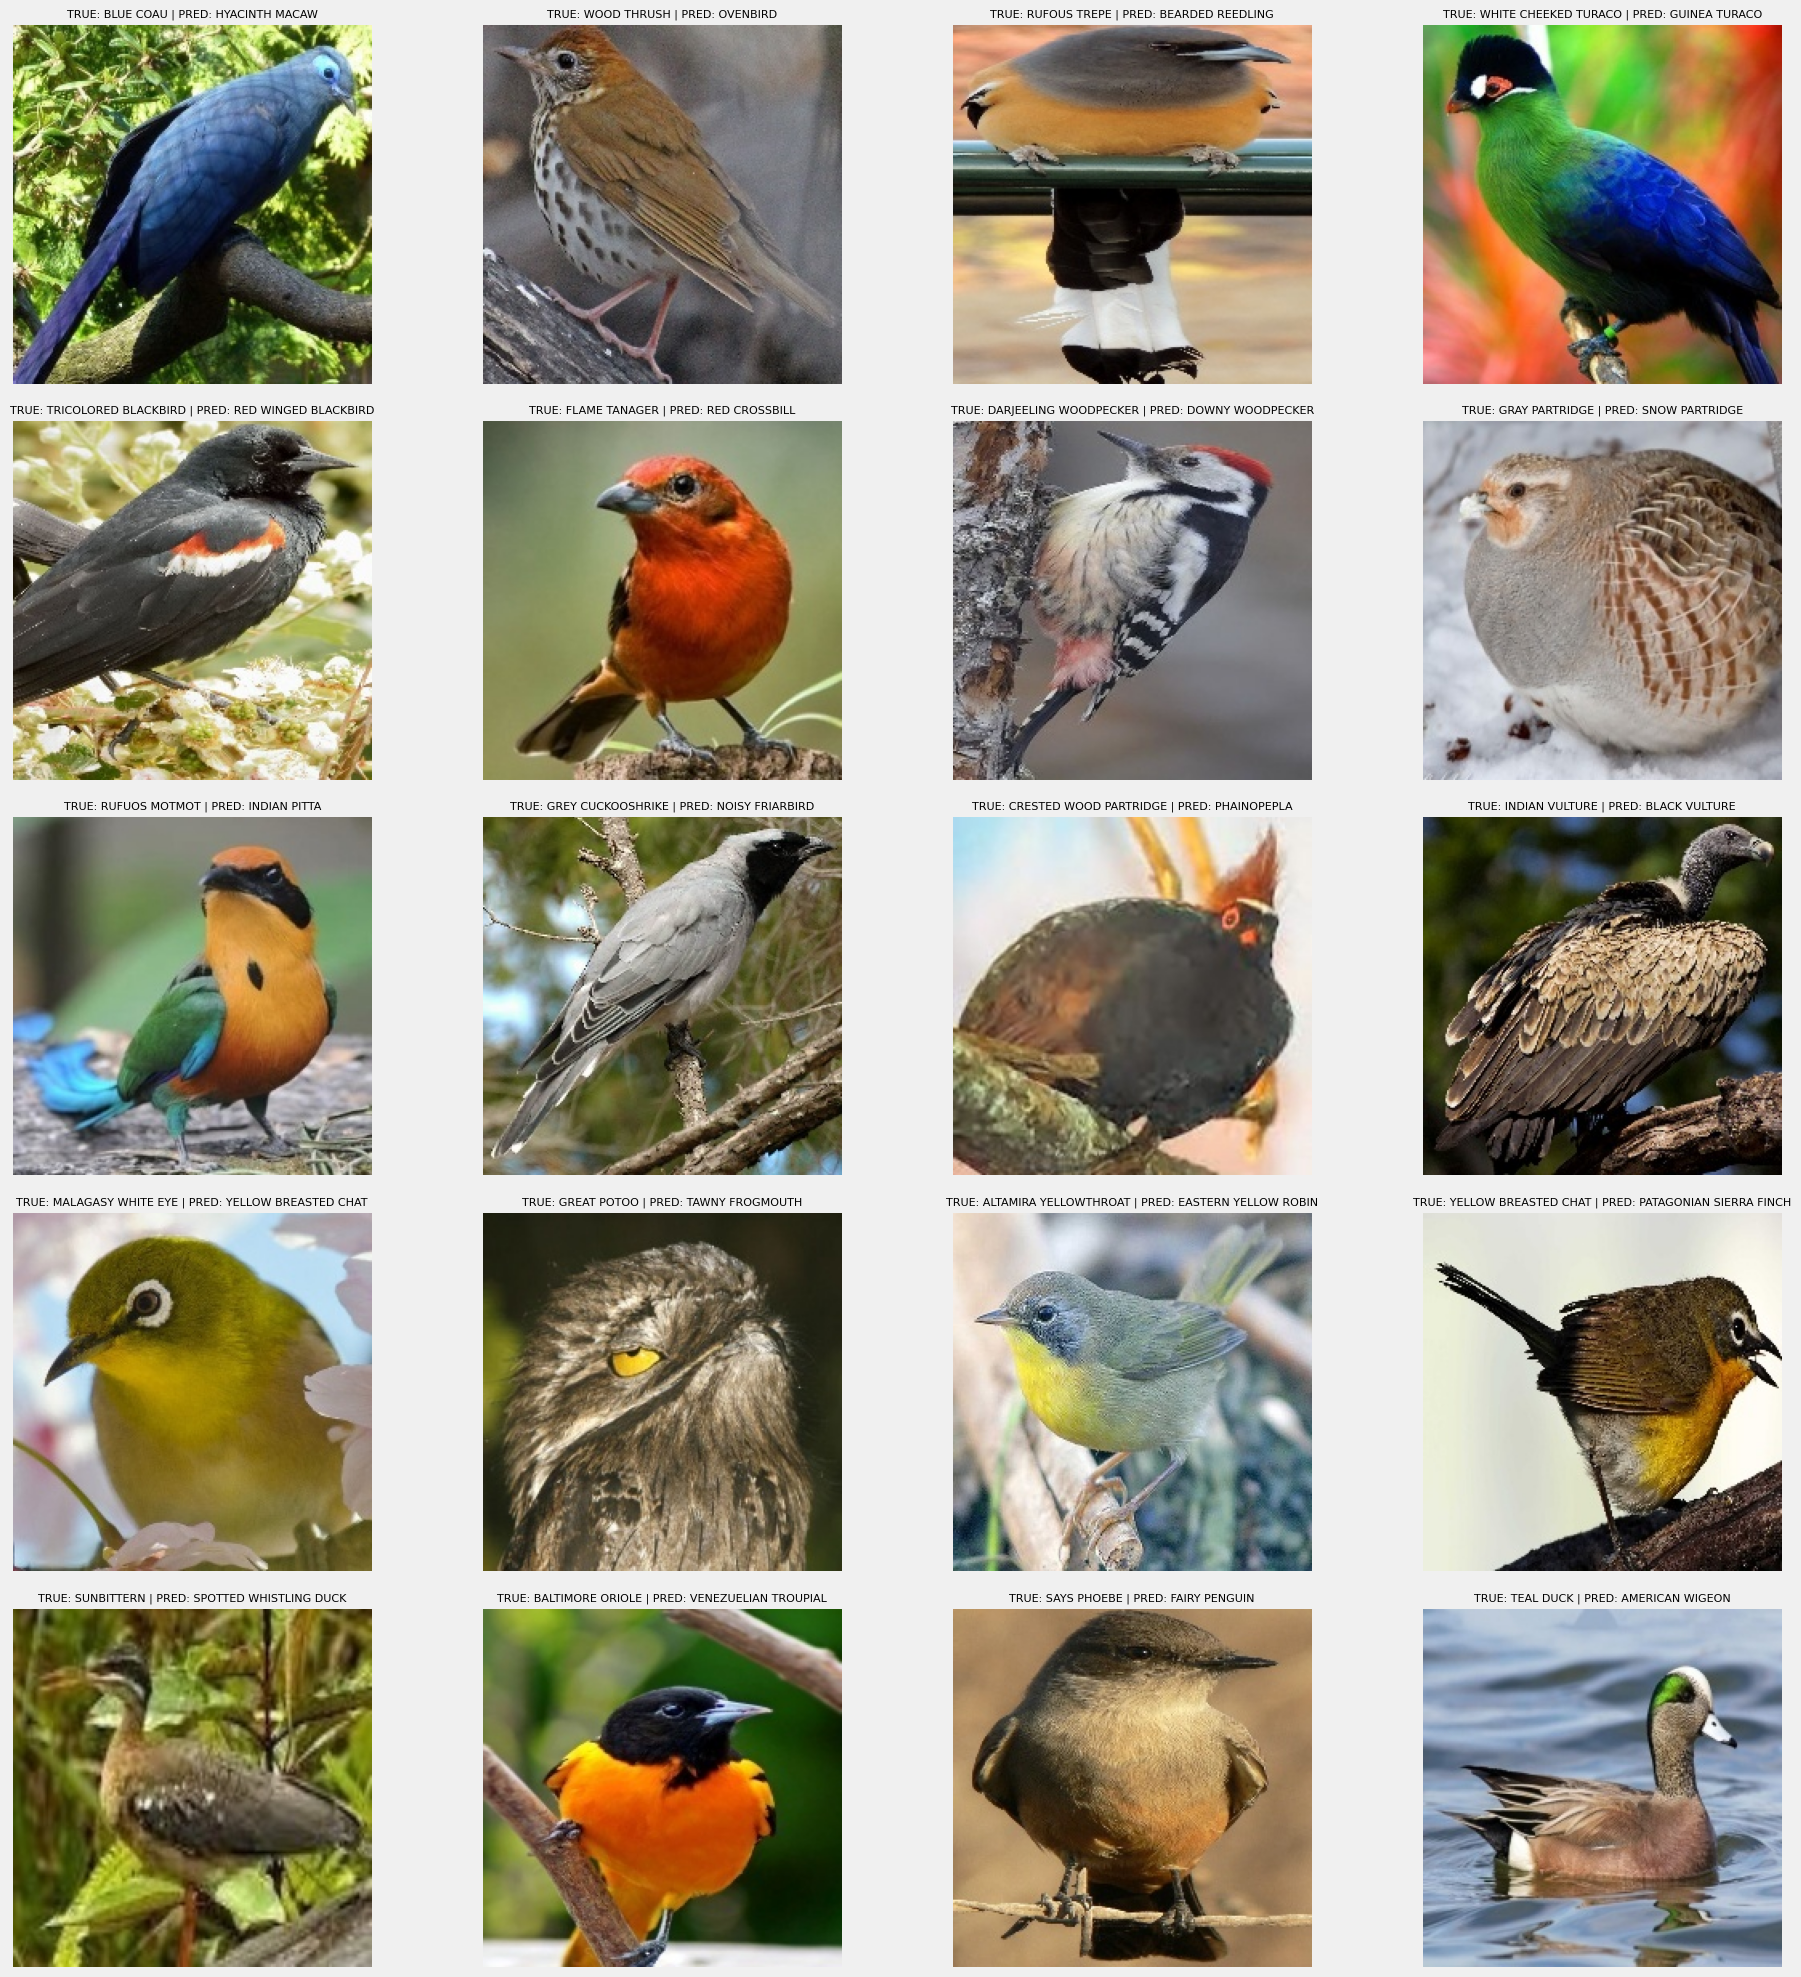

In [21]:
# Add base directory
base_dir = test_images.directory  # base path where images are stored

plt.figure(figsize=(20,20))
wrong_predictions = Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]]
wrong_predictions = wrong_predictions.sort_values("Prediction Probability").tail(20).reset_index()

for i, row in wrong_predictions.iterrows():
    plt.subplot(5, 4, i+1)
    image_path = os.path.join(base_dir, row['Path'])  # Correct full path
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()
